In [1]:
import os
from pathlib import Path
import sys

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import xarray
import rioxarray
import rasterio

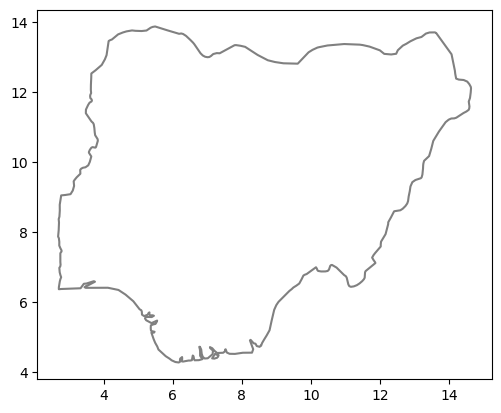

In [2]:
borders = gpd.read_file(Path('../assets/nigeria_borders.shp'))
borders.boundary.plot(color='grey');

## Binary map

### Read raster and convert to numpy array

In [4]:
version = 2
preds_dir = Path(f"../data/predictions/nigeria-cropharvest-full-country-2020/v{version}")
map_type = 'binary' # 'probability'
tif_path = preds_dir / f'combined_{map_type}_uint8_lzw_clipped.tif'
assert tif_path.exists()

In [5]:
# Open and check size in RAM, plot
with rasterio.open(tif_path) as src:
    meta = src.meta
    compress = src.profile['compress']
    data = src.read(1)
meta, compress, data.shape

({'driver': 'GTiff',
  'dtype': 'uint8',
  'nodata': 255.0,
  'width': 132866,
  'height': 106817,
  'count': 1,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
         0.0, -8.983152841193113e-05, 13.872862595714636)},
 'lzw',
 (106817, 132866))

In [6]:
data

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [7]:
nodata_value = meta['nodata']
nodata_value
#masked_data = np.where(data == int(nodata_value), np.nan, data)

255.0

In [8]:
#data_subset = data[:1000, :1000]
#data_subset[data_subset == 0] = np.nan

In [9]:
#values, counts = np.unique(data, return_counts=True)

In [10]:
# https://stackoverflow.com/questions/2578752/how-can-i-plot-nan-values-as-a-special-color-with-imshow-in-matplotlib
arr = np.ma.array(data, mask=(data == int(nodata_value)))
arr

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=999999,
  dtype=uint8)

In [11]:
arr.shape

(106817, 132866)

In [12]:
del data

In [13]:
# strip = 10
# strip_width = 10000
# start = strip * strip_width
# stop = (strip + 1) * strip_width
#value, counts = np.unique(arr[-50000:, start: stop], return_counts=True)
#value

### Plot

In [14]:
from rasterio.plot import show
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as colors
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.metrics.pairwise import haversine_distances

In [15]:
#https://stackoverflow.com/questions/2578752/how-can-i-plot-nan-values-as-a-special-color-with-imshow-in-matplotlib
#arr = np.ma.array(data, mask=(data == int(nodata_value)))
cmap = mpl.cm.get_cmap().copy()
cmap = plt.cm.get_cmap('binary', 2)
cmap.set_bad(color='white')

#colors =["black", "white"]
colors = ["wheat", "green"]
cmap = ListedColormap(colors)

# Define a normalization from values -> colors
norm = mpl.colors.BoundaryNorm([0, 1], 2)

In [16]:
lat, lon = 9.042217, 7.288160
EARTH_RADIUS = 6371000 # meters
A = [lon * np.pi / 180., lat * np.pi / 180.] #Latitude of interest here 40.7 deg, longitude -74.5
B = [(lon + 1) * np.pi / 180., lat * np.pi / 180.] ##Latitude of interest here 40.7 deg, longitude -74.5+1
dx = (EARTH_RADIUS) * haversine_distances([A, B])[0, 1]

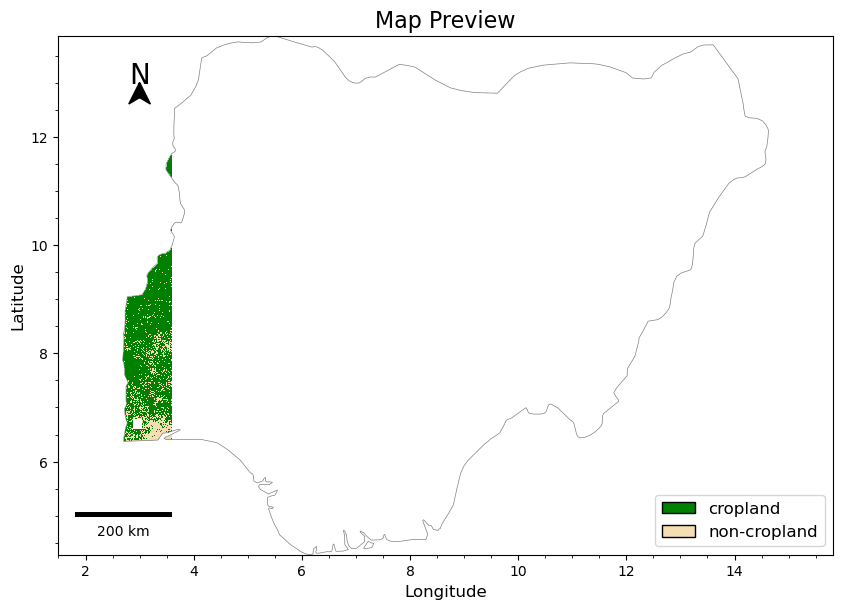

In [19]:
#plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10, 10))
strip = 0
strip_width = 20000
start = strip * strip_width
stop = (strip + 1) * strip_width
#plt.imshow(data[start:stop])
# semi-colon suppresses output, very important for not getting RAM issue as explained here (https://stackoverflow.com/questions/9525706/excessive-memory-usage-in-matplotlib-imshow)
#plt.imshow(arr[-50000:, start: stop], cmap='gray');

borders.boundary.plot(ax=ax, color='grey', linewidth=0.5)
show(arr[:, 0:10000], ax=ax, cmap=cmap, norm=norm, interpolation="nearest", transform=meta['transform']);
#show(arr, ax=ax, cmap=cmap, norm=norm, interpolation="nearest", transform=meta['transform'])

# Legend
legend_labels = {colors[1]: "cropland", colors[0]: "non-cropland"}
patches = [Patch(facecolor=color, label=label, edgecolor="black") for color, label in legend_labels.items()]
ax.legend(handles=patches, facecolor="white", fontsize=12, loc="lower right") #,bbox_to_anchor=(0.98, 0.98))

# North arrow
ax.text(x=3, y=13, s='N', fontsize=20, horizontalalignment='center')
ax.arrow(3, 13 , 0, 0.01, width=0, length_includes_head=True, head_width=0.4, head_length=0.4, overhang=.3, facecolor='k')

# Scale bar
scalebar = ScaleBar(dx, "m", length_fraction=0.25, location="lower left", border_pad=1) # when CRS is in UTM dx can be set to 1
ax.add_artist(scalebar)

#plt.colorbar()
plt.title("Map Preview", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.minorticks_on()
plt.margins(0.1)
#plt.axis("off")

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

map = Basemap(llcrnrlon=3.75,llcrnrlat=39.75,urcrnrlon=4.35,urcrnrlat=40.15, epsg=5520)
#http://server.arcgisonline.com/arcgis/rest/services

map.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)
plt.show()

## Probability map

In [3]:
version = 2
preds_dir = Path(f"../data/predictions/nigeria-cropharvest-full-country-2020/v{version}")
map_type = 'probability' # 'probability'
tif_path = preds_dir / f'combined_{map_type}_uint8_lzw_clipped.tif'
assert tif_path.exists()

In [4]:
# Open and check size in RAM, plot
with rasterio.open(tif_path) as src:
    meta = src.meta
    compress = src.profile['compress']
    data = src.read(1)
meta, compress, data.shape

({'driver': 'GTiff',
  'dtype': 'uint8',
  'nodata': 255.0,
  'width': 132866,
  'height': 106817,
  'count': 1,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(8.983152841193114e-05, 0.0, 2.6916220858073223,
         0.0, -8.983152841193113e-05, 13.872862595714636)},
 'lzw',
 (106817, 132866))

In [5]:
nodata_value = meta['nodata']
nodata_value

255.0

In [6]:
# https://stackoverflow.com/questions/2578752/how-can-i-plot-nan-values-as-a-special-color-with-imshow-in-matplotlib
arr = np.ma.array(data, mask=(data == int(nodata_value))) # too expensive to convert to 0-1 float array so just modify colorbar
arr

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=999999,
  dtype=uint8)

In [9]:
from rasterio.plot import show
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.metrics.pairwise import haversine_distances

In [10]:
cmap = mpl.cm.get_cmap().copy()

In [11]:
lat, lon = 9.042217, 7.288160
EARTH_RADIUS = 6371000 # meters
A = [lon * np.pi / 180., lat * np.pi / 180.] #Latitude of interest here 40.7 deg, longitude -74.5
B = [(lon + 1) * np.pi / 180., lat * np.pi / 180.] ##Latitude of interest here 40.7 deg, longitude -74.5+1
dx = (EARTH_RADIUS) * haversine_distances([A, B])[0, 1]

/mnt/Data/jgajardo/miniconda3/envs/nigeria-crop-mask-gpu3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


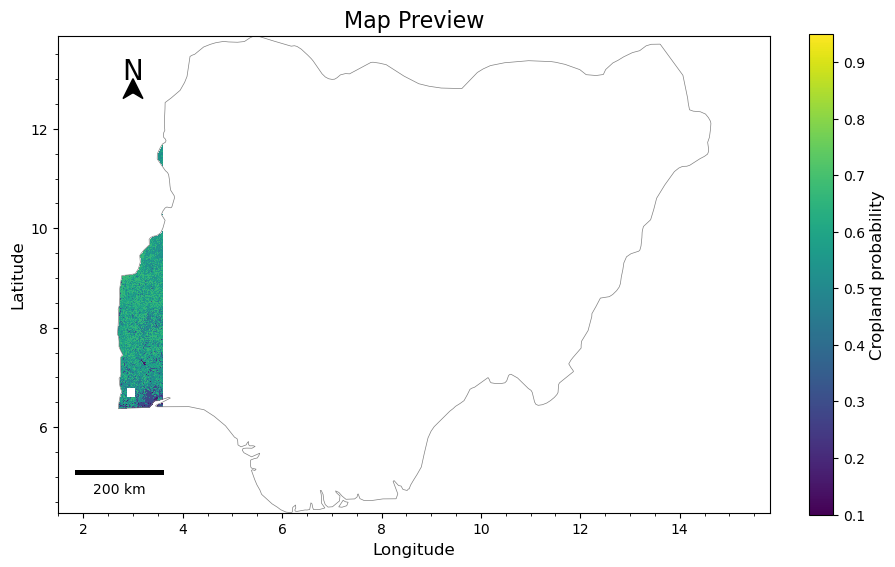

In [55]:
#plt.figure(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10, 10))
strip = 0
strip_width = 20000
start = strip * strip_width
stop = (strip + 1) * strip_width
#plt.imshow(data[start:stop])
# semi-colon suppresses output, very important for not getting RAM issue as explained here (https://stackoverflow.com/questions/9525706/excessive-memory-usage-in-matplotlib-imshow)
borders.boundary.plot(ax=ax, color='grey', linewidth=0.5)
#probability_map = plt.imshow(arr[:, 0:10000], cmap=cmap);

ax = show(arr[:, 0:10000], ax=ax, cmap=cmap, interpolation="nearest", transform=meta['transform']);
#show(arr[:, 0:10000], ax=ax, cmap=cmap, norm=norm, interpolation="nearest", transform=meta['transform']);

# Legend
# legend_labels = {colors[1]: "cropland", colors[0]: "non-cropland"}
# patches = [Patch(facecolor=color, label=label, edgecolor="black") for color, label in legend_labels.items()]
# ax.legend(handles=patches, facecolor="white", fontsize=12, loc="lower right") #,bbox_to_anchor=(0.98, 0.98))

# North arrow
ax.text(x=3, y=13, s='N', fontsize=20, horizontalalignment='center')
ax.arrow(3, 13 , 0, 0.01, width=0, length_includes_head=True, head_width=0.4, head_length=0.4, overhang=.3, facecolor='k')

# Scale bar
scalebar = ScaleBar(dx, "m", length_fraction=0.25, location="lower left", border_pad=1) # when CRS is in UTM dx can be set to 1
ax.add_artist(scalebar)

# Colorbar
cbar = plt.colorbar(ax.get_images()[0], ax=ax, fraction=0.031)
tick_labels = [f'{tick/100:.1f}' for tick in cbar.get_ticks()]
cbar.set_ticklabels(tick_labels)
cbar.set_label('Cropland probability', fontsize=12)

# Common stuff
plt.title("Map Preview", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.minorticks_on()
plt.margins(0.1)
#plt.axis("off")

In [48]:
cbar.get_ticks()

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [50]:
labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [51]:
cbar.set_ticklabels(labels)

/mnt/Data/jgajardo/miniconda3/envs/nigeria-crop-mask-gpu3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: FixedFormatter should only be used together with FixedLocator
  """Entry point for launching an IPython kernel.


In [52]:
cbar.get_ticks()

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])